In [71]:
from transformers import AutoImageProcessor, AutoModel

In [72]:
image_processor = AutoImageProcessor.from_pretrained(
    "google/efficientnet-b0"
)
model = AutoModel.from_pretrained("google/efficientnet-b0")

In [73]:
import torch

# Create a dummy input matching the model's expected input shape (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model to ONNX
torch.onnx.export(
    model,
    dummy_input,
    "efficientnet_b0.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=12,
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print("Model exported to efficientnet_b0.onnx")

Model exported to efficientnet_b0.onnx


/Users/rutger/Library/Caches/pypoetry/virtualenvs/reverse-image-search-6WPQ4Vfh-py3.11/lib/python3.11/site-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:180.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/Users/rutger/Library/Caches/pypoetry/virtualenvs/reverse-image-search-6WPQ4Vfh-py3.11/lib/python3.11/site-packages/torch/onnx/utils.py:657: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:180.)
  _C._jit_pass_onnx_unpack_quantized_weights(graph, params_dict)
/Users/rutger/Library/Caches/pypoetry/virtualenvs/reverse-ima

In [74]:
from pathlib import Path
from PIL import Image

def load_image(image: str | Path ):
    """
    Loads an image and processes it using the model's image processor.
    Reusable helper function for single and batch image processing.
    """
    if isinstance(image, str) or isinstance(image, Path):
        image = Image.open(image)
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    elif not isinstance(image,Image.Image):
        return None

    if image.mode != "RGB":
        image = image.convert("RGB")

    image_2 = image_processor(images=image, return_tensors="pt")

    return image, image_2["pixel_values"]

image, image_2 = load_image(image="images/ZUR4694.jpg")

In [ ]:
from PIL import Image
import torch

# Resize the image to (224, 224)
image_resized = image.resize((224, 224), Image.BILINEAR)

# Convert PIL image to numpy array and scale to [0, 1]
img_arr = np.asarray(image_resized).astype(np.float32) / 255.0

# Convert to (C, H, W) format
img_arr = np.transpose(img_arr, (2, 0, 1))

# Convert to torch tensor and add batch dimension
image_tensor = torch.from_numpy(img_arr).unsqueeze(0)

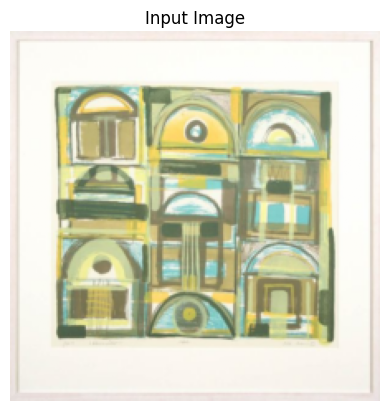

In [76]:
import matplotlib.pyplot as plt

# image is a torch.Tensor of shape (1, 3, H, W), remove batch dimension and convert to numpy
img_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# EfficientNet preprocessing normalizes the image, so to visualize, unnormalize to [0, 1] range
# mean = image_processor.image_mean
# std = image_processor.image_std
# img_np = (img_np * std) + mean
# img_np = img_np.clip(0, 1)

plt.imshow(img_np)
plt.axis('off')
plt.title("Input Image")
plt.show()

In [77]:
import onnxruntime as ort
import numpy as np

# Convert dummy_input to numpy array
input_numpy = image_tensor.cpu().numpy()

# Create ONNX Runtime session
session = ort.InferenceSession("efficientnet_b0.onnx")

# Run inference
outputs = session.run(None, {"input": input_numpy})

print("ONNX Runtime output shape:", outputs[1].squeeze().shape)

ONNX Runtime output shape: (1280,)


In [78]:
outputs[1]

array([[ 3.2742886e-05,  1.9724450e-05, -3.3536301e-06, ...,
         2.6893163e-06,  1.9321371e-06,  3.9278177e-05]],
      shape=(1, 1280), dtype=float32)

In [80]:
model.eval()  # Set the model to evaluation mode
output = model(image_2)  # This will run the model on the input tensor
output[1]

tensor([[ 7.7690e-01,  2.6822e-01, -1.3360e-01,  ..., -1.2180e-03,
          2.7897e-01,  1.6971e+00]], grad_fn=<ViewBackward0>)